Many pitfalls to guessing a linthresh value that stem from precision rounding issues. Some of the issues are internal to matplotlib, some are more general rounding issues. 

Let's start with examples...



In [1]:
import matplotlib.pyplot as plt 
from matplotlib.colors import SymLogNorm, LogNorm
import yt
import numpy as np

Taking the early problematic example from issue # 

yt : [INFO     ] 2022-07-08 12:42:53,971 Calculating time from 1.000e+00 to be 4.355e+17 seconds
yt : [INFO     ] 2022-07-08 12:42:53,972 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2022-07-08 12:42:54,029 Parameters: current_time              = 4.3545571088051405e+17 s
yt : [INFO     ] 2022-07-08 12:42:54,030 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-07-08 12:42:54,030 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-08 12:42:54,031 Parameters: domain_right_edge         = [60000. 60000. 60000.]
yt : [INFO     ] 2022-07-08 12:42:54,031 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-08 12:42:54,032 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2022-07-08 12:42:54,032 Parameters: omega_lambda              = 0.728
yt : [INFO     ] 2022-07-08 12:42:54,032 Parameters: omega_matter              = 0.272
yt : [INFO     ] 2022-07-08 12:42:54,033 Parameters: omega_radiation           = 0.


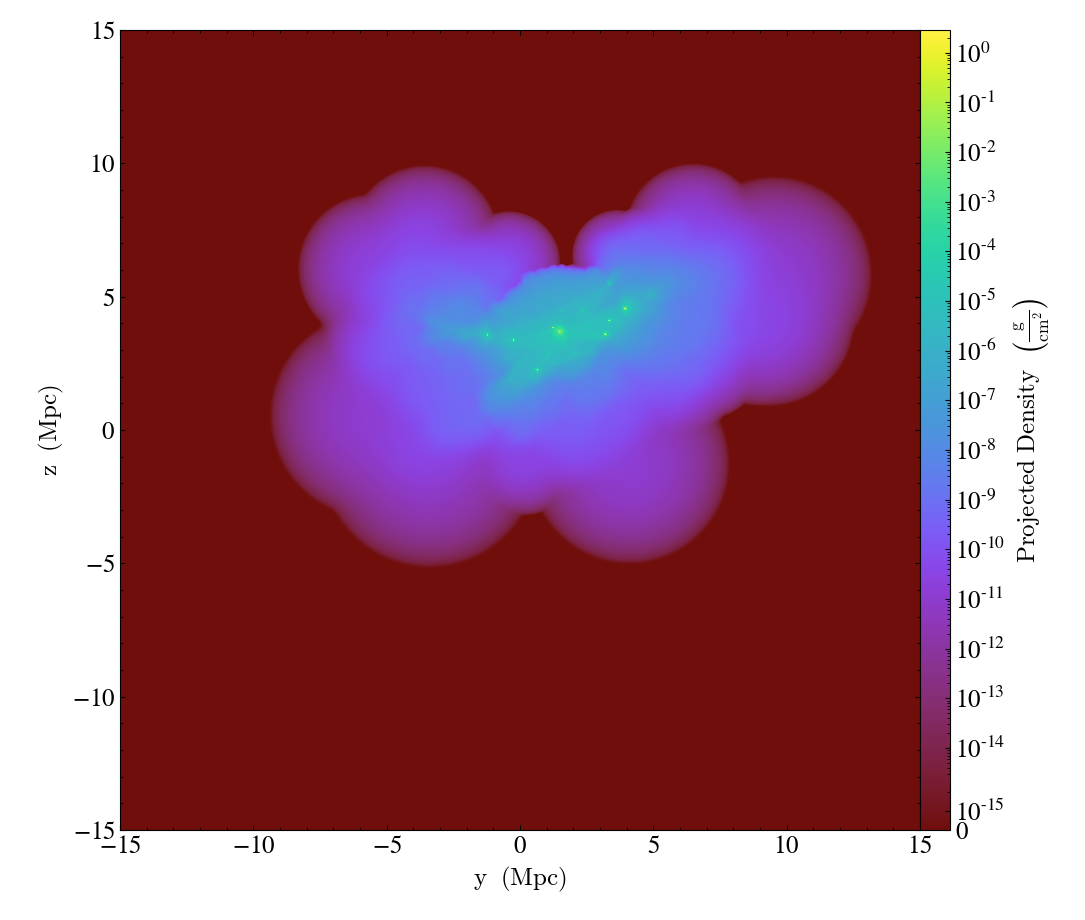

In [2]:
fn = 'FIRE_M12i_ref11/snapshot_600.hdf5'
ds = yt.load(fn)
p = yt.ProjectionPlot(ds, 'x', ('gas', 'density'), width=(30, 'Mpc'))
p.show()

yt : [INFO     ] 2022-07-08 12:42:56,848 Parameters: current_time              = 6433617486134.068
yt : [INFO     ] 2022-07-08 12:42:56,849 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-08 12:42:56,849 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-08 12:42:56,850 Parameters: domain_right_edge         = [4.9376e+20 4.9376e+20 4.9376e+20]
yt : [INFO     ] 2022-07-08 12:42:57,129 xlim = 0.000000 493760000000000000000.000000
yt : [INFO     ] 2022-07-08 12:42:57,130 ylim = 0.000000 493760000000000000000.000000
yt : [INFO     ] 2022-07-08 12:42:57,130 xlim = 0.000000 493760000000000000000.000000
yt : [INFO     ] 2022-07-08 12:42:57,131 ylim = 0.000000 493760000000000000000.000000
yt : [INFO     ] 2022-07-08 12:42:57,137 Making a fixed resolution buffer of (('boxlib', 'scalar')) 800 by 800



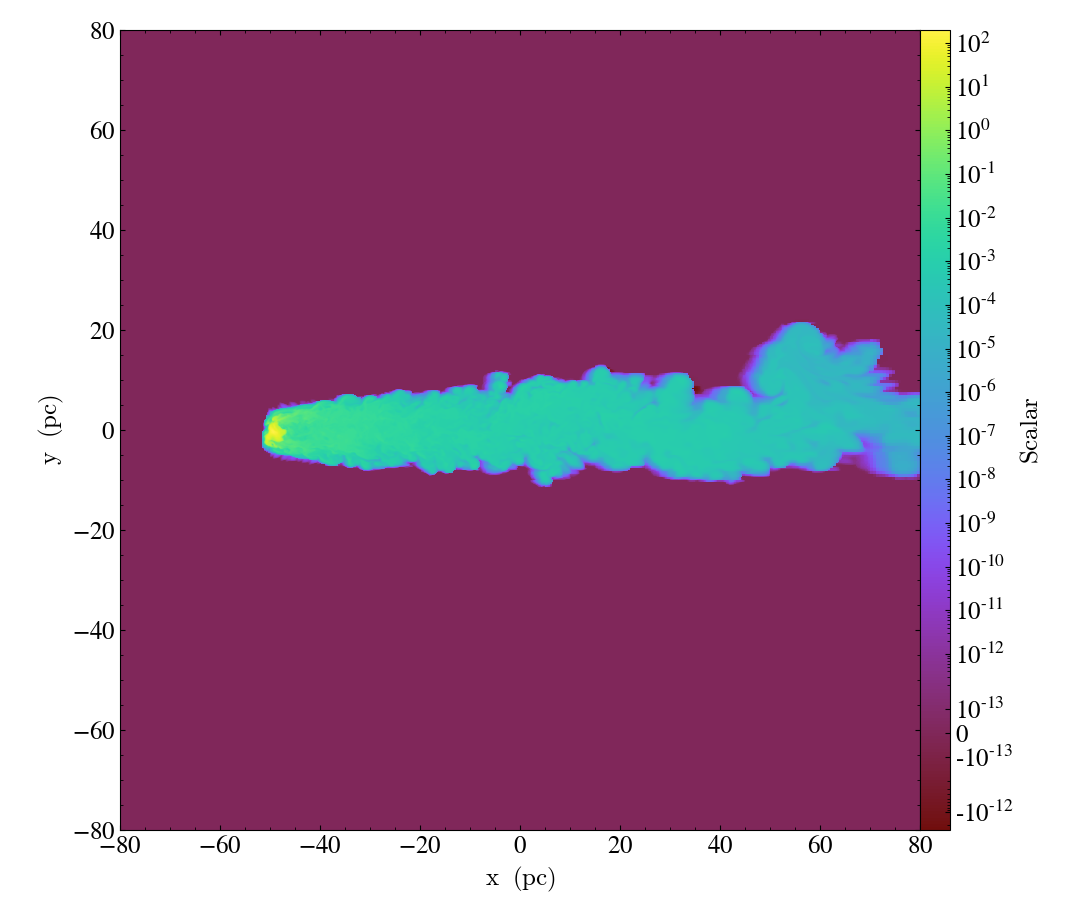

In [3]:
import yt

ds = yt.load('symlogsets/yt_bug_reproducer/plt04000')
slc = yt.SlicePlot(ds, "z", ("boxlib", "scalar"))
slc.show()

yt : [INFO     ] 2022-07-08 12:50:44,562 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-07-08 12:50:44,563 Parameters: domain_dimensions         = [64 64  1]
yt : [INFO     ] 2022-07-08 12:50:44,564 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-08 12:50:44,564 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-08 12:50:44,564 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2022-07-08 12:50:44,702 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-07-08 12:50:44,702 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-07-08 12:50:44,703 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-07-08 12:50:44,703 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-07-08 12:50:44,709 Making a fixed resolution buffer of (('stream', 'linthresh_symmetric')) 800 by 800



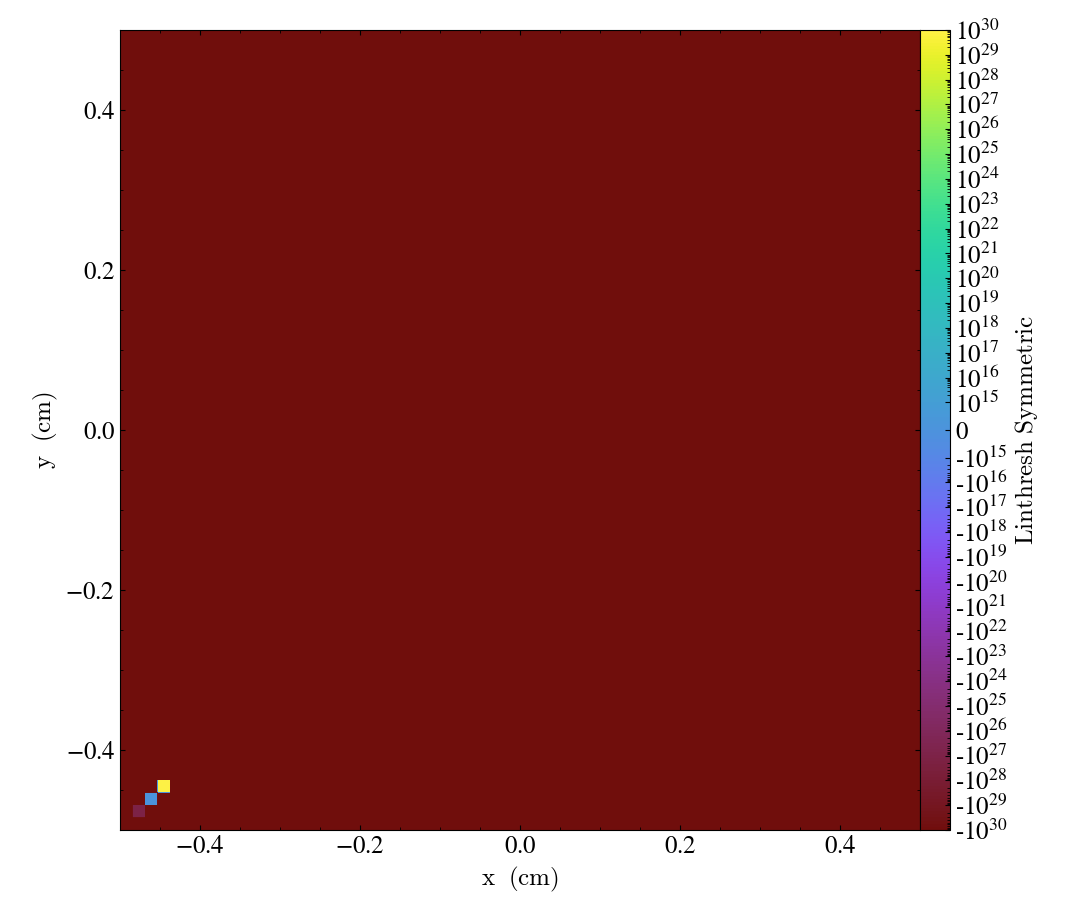

In [4]:
shape = (64, 64, 1)
arr = np.full(shape, -1e30)
arr[1, 1] = -1e27
arr[2, 2] = 1e10
arr[3, 3] = 1e30
d = {"linthresh_symmetric": arr}

ds = yt.load_uniform_grid(d, shape)
p = yt.SlicePlot(ds, "z", "linthresh_symmetric")
p

In [6]:
n.vmax

3.549929801742279

In [7]:
n.vmin

0.0

In [8]:
n.linthresh

4.8845906468177196e-23

## matplotlib lognorm issue: why switch to symlog at all? 

The fix to https://github.com/yt-project/yt/issues/2890 was to switch to symlog in some situations, but it's worth revisiting that choice. 

The underlying issue when using a lognorm with a very large data range in matplotlib is that there are known issues that come from rounding issues. Sometimes this results in artifacts:

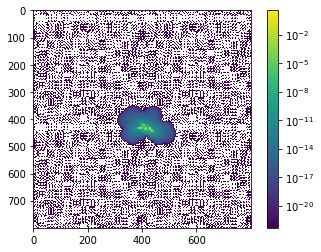

In [20]:
plt.imshow(vals, norm=LogNorm())
plt.colorbar()

sometimes it results in hard errors. Here I'm using the projection plot to get a layout consistent with what yt does:

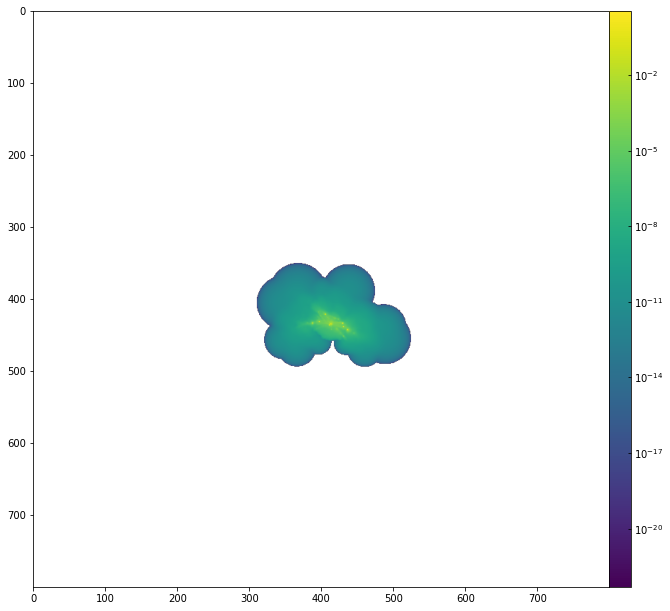

In [43]:
from matplotlib.figure import Figure


pgd = p[('gas', 'density')]
fsize, axrect, caxrect = pgd._get_best_layout()
f = Figure(fsize)
ax = f.add_axes(axrect)
cax = f.add_axes(caxrect)

ln = LogNorm(vmin=vals[vals>0].min(), vmax=vals.max())
im = ax.imshow(vals, norm=ln, interpolation_stage='rgba')
cb = f.colorbar(im, cax)
cax.tick_params(which="both", axis="y", direction="in")
cax.minorticks_on()
cax.xaxis.set_visible(False)
f

<AxesSubplot:>

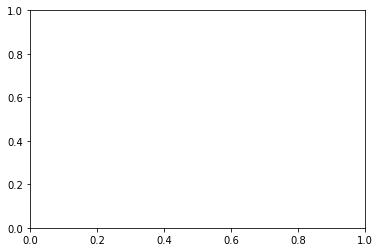

matplotlib 3.5.2 introduced a new keyword argument to imshow that on the surface solves this:

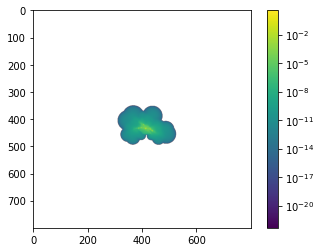

In [21]:
plt.imshow(vals, norm=LogNorm(), interpolation_stage="rgba")
plt.colorbar()

so why not switch to using this in yt when available and avoid using symlog at all in these situations? Two reasons:

1. a technical argument: the base norm objects, which yt uses directly for things like tick formatting do **not** have this extra argument and so we can still get errors. 
2. a conceptual argument: the zero values in this case come from initializing the buffer with zeros. but we have no way of knowing if the zero values are actual data values and so it seems better to 

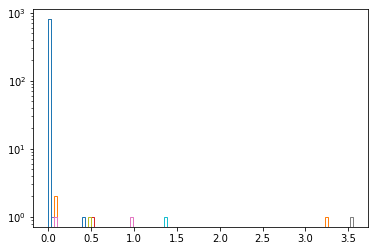

In [8]:
f = plt.hist(vals, histtype='step', log=True, bins=100)

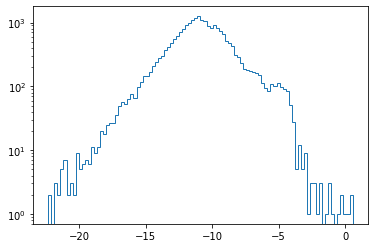

In [15]:
f = plt.hist(np.log10(vals[vals>0]), histtype='step', log=True, bins=100)

In [6]:
import yt 
import numpy as np

shape = (64, 64, 1)
arr = np.full(shape, -5e-320)
arr[1, 1] = -5e-324
arr[2, 2] = 5e-324
arr[3, 3] = 5e-320
d = {"toughmuffins": arr}
ds = yt.load_uniform_grid(d, shape)
p = yt.SlicePlot(ds, "z", ("stream", "toughmuffins"))

yt : [INFO     ] 2022-07-08 12:26:39,649 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-07-08 12:26:39,650 Parameters: domain_dimensions         = [64 64  1]
yt : [INFO     ] 2022-07-08 12:26:39,650 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-08 12:26:39,651 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-08 12:26:39,652 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2022-07-08 12:27:00,733 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-07-08 12:27:00,733 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-07-08 12:27:00,734 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-07-08 12:27:00,734 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-07-08 12:27:00,740 Making a fixed resolution buffer of (('stream', 'toughmuffins')) 800 by 800
/home/chavlin/miniconda3/envs/yt_dev/lib/python3.9/site-packages/matplotlib/scale.py:369: RuntimeWarning: overflow encountered in true_divide
  np.log(abs_a / self.linthresh) / self._log_base)


ValueError: Invalid vmin or vmax